In [1422]:
import numpy as np
import pandas as pd
from datetime import date
import pickle as pkl
import os
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition



In [1423]:
ingredients_recipes = {}
author_recipes = {}
time_recipes = {}
recipe_review = {}

In [1424]:
def read_file(path):
    file = pd.read_csv(path)
    df = pd.DataFrame(file)
    return df

In [1425]:
def create_array_time(df):
    array_time = []

    for i in range(len(df)):
        time = df["Total Time"][i]
        if time == "X":
            array_time.append(0)
        elif len(time) == 3:      #1 d ou 1 h ou 1 m                                      
            divide = time.split(" ")
            if divide[1] == "h":
                array_time.append(int(divide[0]) * 60)
            elif divide[1] == "m":
                array_time.append(int(divide[0]))
            elif divide[1] == "d":
                array_time.append(int(divide[0]) * 24 * 60)
        elif len(time) == 4:    #30 m ou 10 h
            if 'm' in time:
                array_time.append(int(time.split(" m")[0]))
            elif 'h' in time:
                array_time.append(int(time.split(" h")[0]) * 60)
            
        elif len(time) == 8 or len(time) == 7:
            t = 0
            if 'd' in time:     #1 d 1 h ou 1 d 30 m
                divide = time.split(" d ")
                t += int(divide[0]) * 60 * 24
                if 'm' in divide[1]:
                    t += int(divide[1].split(" m")[0])
                elif 'h' in divide[1]:
                    t += int(divide[1].split(" h")[0]) * 60
            elif 'h' in time:       #12 h 2 m ou 1 h 20 m ou 1 h 2 m
                divide = time.split(" h ")
                t += int(divide[0]) * 60 + int(divide[1].split(" m")[0])
            
            array_time.append(t)
        elif len(time) == 9:    #12 h 20 m ou 12 d 12 h ou 12 d 20 m
            t = 0
            if "d" in time:
                divide = time.split(" d ")
                t += int(divide[0]) * 24 * 60
                if "m" in divide[1]:
                    t += int(divide[1].split(" m")[0])
                elif "h" in divide[1]:
                    t += int(divide[1].split(" h")[0])
            elif "h" in time:
                divide = time.split(" h ")
                t += int(divide[0]) * 60 + int(divide[1].split(" m")[0])
            array_time.append(t)
        elif len(time) == 11 or len(time) == 12 or len(time) == 13 or len(time) == 14:     #1 d 1 h 5 m ou 1 d 1 h 50 m ou 1 d 10 h 50 m ou 10 d 10 h 50 m
            divide = time.split(" d ")
            t = int(divide[0]) * 24 * 60
            div = divide[1].split(" h ")
            t += int(div[0]) * 60 + int(div[1].split(" m")[0])
            array_time.append(t)
            
    return array_time

In [1426]:
def create_array_review(df):
    array_review = []
    for i in range(len(df)):
        review = df["Review Count"][i]
        if "k" in review:
            array_review.append(int(review.split("k")[0]) * 1000)
        else:
            array_review.append(int(review))
    return array_review

In [1427]:
def create_ingredients_recipes(df):
    for i in range(len(df)):
        ingredients = df["Ingredients"][i]
        list_ingred = ingredients.split(',')
        for ing in list_ingred:
            if ing not in ingredients_recipes:
                ingredients_recipes[ing] = [df["Recipe Name"][i]]
            else:
                ingredients_recipes[ing].append(df["Recipe Name"][i])

In [1428]:
def create_author_recipes(df):
    for i in range(len(df)):
        author = df["Author"][i]
        if author not in author_recipes:
            author_recipes[author] = [df["Recipe Name"][i]]
        else:
            author_recipes[author].append(df["Recipe Name"][i])

In [1429]:
def create_time_recipes(df):
    global time_recipes
    for i in range(len(df)):
        time = df["Total Time (min)"][i]
        if time not in time_recipes:
            time_recipes[time] = [df["Recipe Name"][i]]
        else:
            time_recipes[time].append(df["Recipe Name"][i])
            
    time_recipes = dict(sorted(time_recipes.items()))
    del time_recipes[0]

In [1430]:
def create_recipe_review(df):
    for i in range(len(df)):
        recipe_review[df["Recipe Name"][i]] = df["Review Count"][i]
    

In [1431]:
def plot_distributions(dic, title, xlabel, ylabel, number, orientation, x, y, fontesize):
    x_values = [i for i in dic if len(dic[i]) > number]
    y_values = [len(dic[i]) for i in dic if len(dic[i]) > number]
    
    plt.figure(figsize=(x, y))
    plt.bar(x_values, y_values, color='blue')                
    plt.title(title)
    plt.xticks(rotation=orientation, fontsize=fontesize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [1432]:
def plot_top10_distributions(dic, top, title, xlabel, ylabel, orientation, x, y, is_list):
    if is_list:
        new_dic = dict(sorted(dic.items(), key=lambda x: len(x[1]), reverse=True))
        x_values = []
        y_values = []
        count = 0
        for i in new_dic:
            x_values.append(i)
            y_values.append(len(new_dic[i]))
            if count == top:
                break
            count += 1
    else:
        new_dic = dict(sorted(dic.items(), key=lambda x: x[1], reverse=True))
        x_values = []
        y_values = []
        count = 0
        for i in new_dic:
            x_values.append(i)
            y_values.append(new_dic[i])
            if count == top:
                break
            count += 1
    
    plt.figure(figsize=(x, y))
    plt.bar(x_values, y_values, color='blue')                
    plt.title(title)
    plt.xticks(rotation=orientation)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


In [1433]:
def plot_pca(df):
    variables = ["Total Time (min)", "Review Count"]

    x = df[variables]

    data = StandardScaler().fit_transform(x)
    pca = decomposition.PCA()
    pca.n_components = 2
    pca_data = pca.fit_transform(data)
    percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
    cum_var_explained = np.cumsum(percentage_var_explained)
    plt.figure(1, figsize=(6, 4))
    plt.plot(cum_var_explained, linewidth=2)
    plt.axis('tight')
    plt.grid()
    plt.xlabel('principal components')
    plt.ylabel('Cumulative variance explained')
    plt.title('PCA: components selection')
    plt.show()

In [1434]:
def user_interface():
    print("-"*40 + " Welcome to Pendia " + "-"*40)
    print("1- Log In;\n2- Sing In;\n0- Leave;")
    option = input("1- Log In\n2- Sing In\n0- Leave\n")
    print(option)
    name = ""
    password = ""
    state = False
    while option != "0":
        if os.path.exists("users.pkl"):
            with open("users.pkl", 'rb') as arq:
                d_users =  pkl.load(arq)
        else:
            d_users = {}
        if option == "1" and d_users == {}:
            print("Without users")
        elif option == "1":
            while(1):
                name = input("Name: ")
                print("Name: " + name)
                if name in d_users:
                    break
                else:
                    print("Incorret Name")
            while(1):
                password = input("Password: ")
                print("Password: " + password)
                if d_users[name] == password:
                    break
                else:
                    print("Incorret Password")
            print("-"*40 + " Hi " + name + " " + "-"*40)
            state = True
        elif option == "2":
            while(1):
                name = input("Name: ")
                print("Name: " + name)
                if name not in d_users:
                    password = input("Password: ")
                    print("Password: " + password)
                    d_users[name] = password
                    break
                else:
                    print("User Already exists")
            with open("users.pkl", 'wb') as arq:
                pkl.dump(d_users, arq)
            print("-"*40 + " Hi " + name + " " + "-"*40)
            state = True
        else:
            print("Invalid Option")
        
        if state:
            option = "0"
        else:
            print("1- Log In;\n2- Sing In;\n0- Leave;")
            option = input("1- Log In;\n2- Sing In;\n0- Leave;\n")
            print(option)
    if state:
        path = "dataset/" + name + ".csv"
        df = read_file(path)
        display(df)
    else: 
        print("Bye, Have a Great Time!")
        return
    

        
    


In [1435]:
def main():
    path = "dataset/"
    if os.path.exists("Final_recipes.csv"):
        path += "Final_recipes.csv"
        df = read_file(path)
    else:
        path += "clean_recipes.csv"
        df = read_file(path)
        array_time = create_array_time(df)
        df["Total Time (min)"] = array_time
        array_review = create_array_review(df)
        df["Review Count"] = array_review
        df.to_csv("dataset/Final_recipes.csv")

    display(df)
    create_ingredients_recipes(df)
    create_author_recipes(df)
    create_time_recipes(df)
    create_recipe_review(df)

    top = 10
    plot_distributions(ingredients_recipes, "Ingredients Distribution", "Ingredients", "Number of Recipes", 100, "vertical", 15, 5, 5) 
    plot_top10_distributions(ingredients_recipes, top, "Top 10 Ingredients Distribution", "Top 10 Ingredients", "Number of Recipes", "horizontal", 10, 5, True)
    
    plot_distributions(author_recipes, "Author Distribution", "Authors", "Number of Recipes", 5, "vertical", 15, 5, 4) 
    plot_top10_distributions(author_recipes, top, "Top 10 Authors Distribution", "Top 10 Authors", "Number of Recipes", "vertical", 10, 5, True)
    
    plot_distributions(time_recipes, "Time Distribution", "Time (min)", "Number of Recipes", 5, "horizontal", 15, 5, 10) 
    plot_top10_distributions(time_recipes, top, "Top 10 Times Distribution", "Top 10 Times (min)", "Number of Recipes", "horizontal", 10, 5, True)

    plot_top10_distributions(recipe_review, top, "Top 10 Recipes Distribution", "Top 10 Recipes", "Review", "vertical", 10, 5, False)
    plot_pca(df)   
    
    user_interface()

    
    

,Unnamed: 0,Recipe Name,Review Count,Author,Total Time,Ingredients,Directions,RecipeID,Total Time (min)
0,0,Golden Crescent Rolls Recipe,304,Mike A.,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000,190
1,1,Poppy Seed Bread with Glaze Recipe,137,Christina Jun,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001,80
2,2,Applesauce Bread I Recipe,124,GAF55,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003,90
3,3,Apple Raisin Bread Recipe,39,Helen Hanson,1 h 15 m,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....,7006,75
4,4,Buttermilk Oatmeal Bread Recipe,41,Helen Hanson,1 h 40 m,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...,7007,100
...,...,...,...,...,...,...,...,...,...
12346,12346,Hot Coffee Frosting Recipe,5,Jean,1 h,"sugar,butter,cocoa powder,vanilla,coffee","'In a large bowl, combine confectioners'' suga...",27456,60
12347,12347,White Chocolate Blueberry Cheesecake Recipe,78,Scott M.,1 h 20 m,"CRUST:,ham,almond,white sugar,butter,caramel,F...",Preheat oven to 275 degrees F (135 degrees C)....,27478,80
12348,12348,'Aunt Anne''s Coffee Cake Recipe ',704,Mary,45 m,"flour,white sugar,baking powder,salt,butter,eg...",Preheat oven to 350 degrees F (175 degrees C)....,27491,45
12349,12349,Giant Ding Dong Cake Recipe,157,TheThreeDogKitchen,2 h 15 m,"cake,chocolate,egg,water,vegetable oil,flour,m...",Preheat oven to 350 degrees F (175 degrees C)....,27511,135


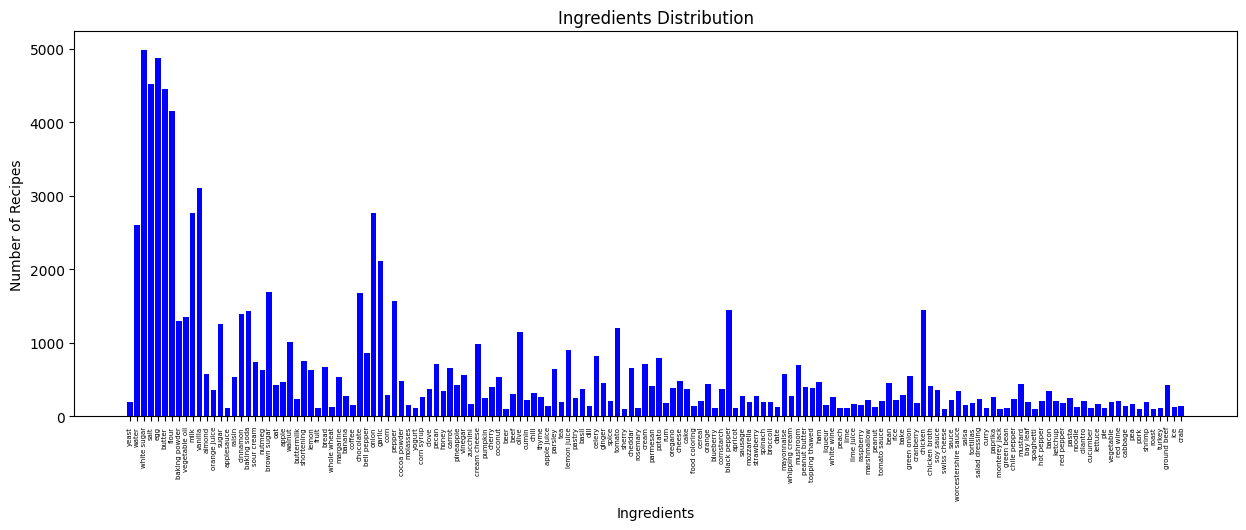

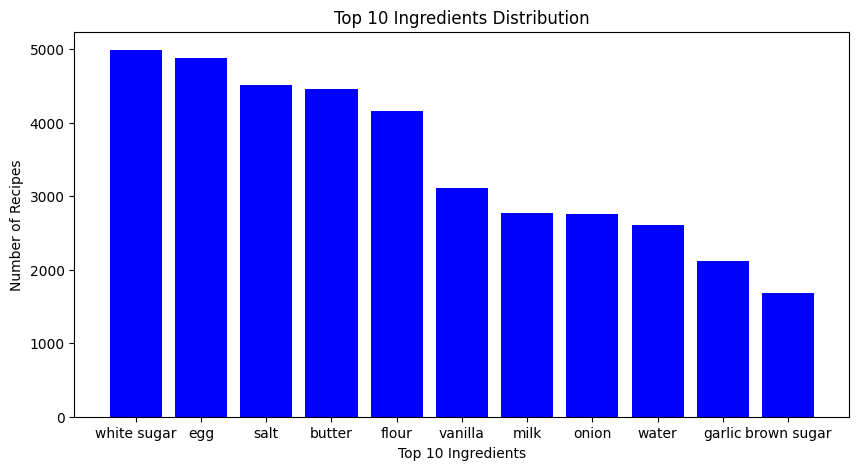

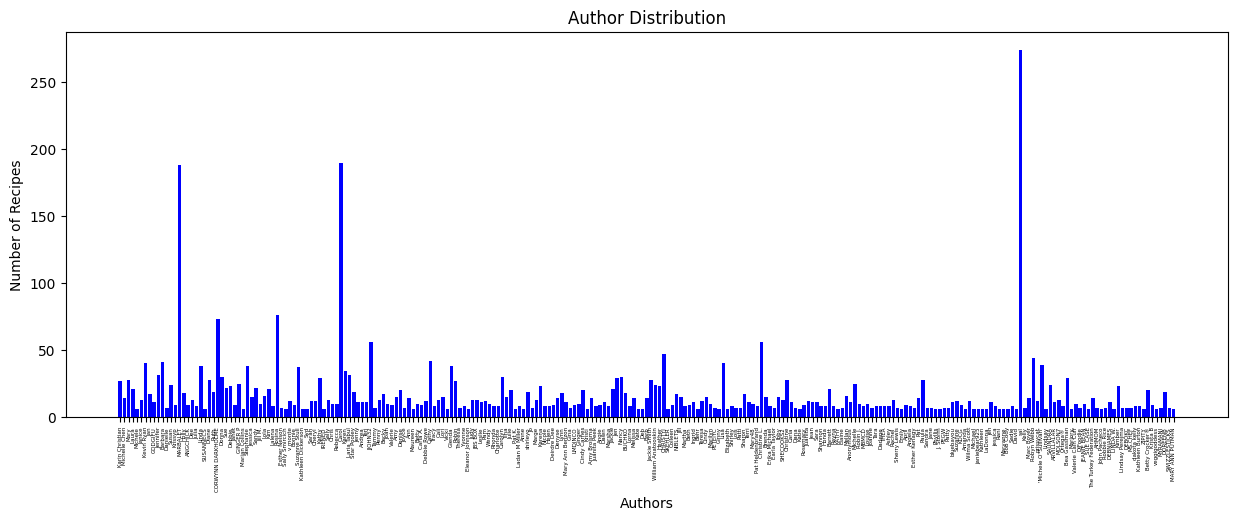

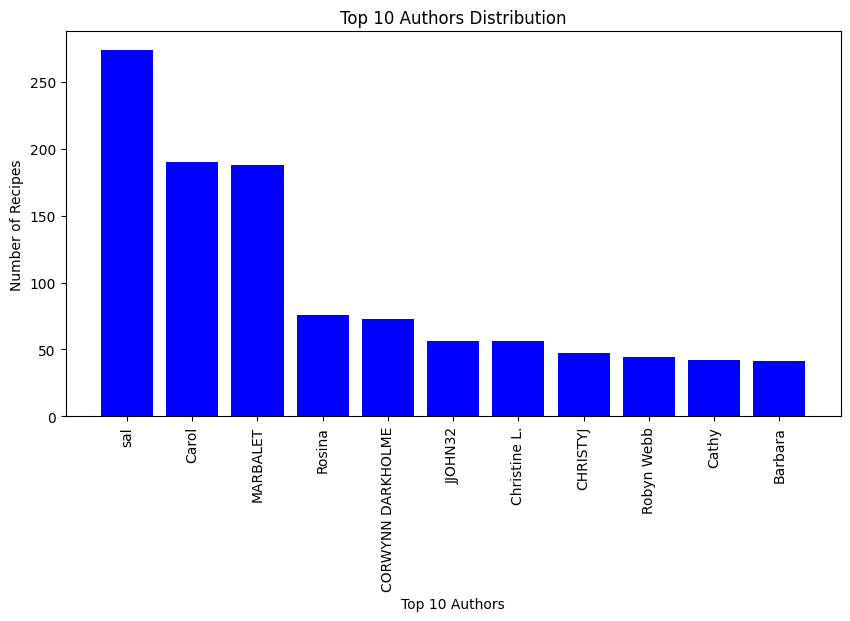

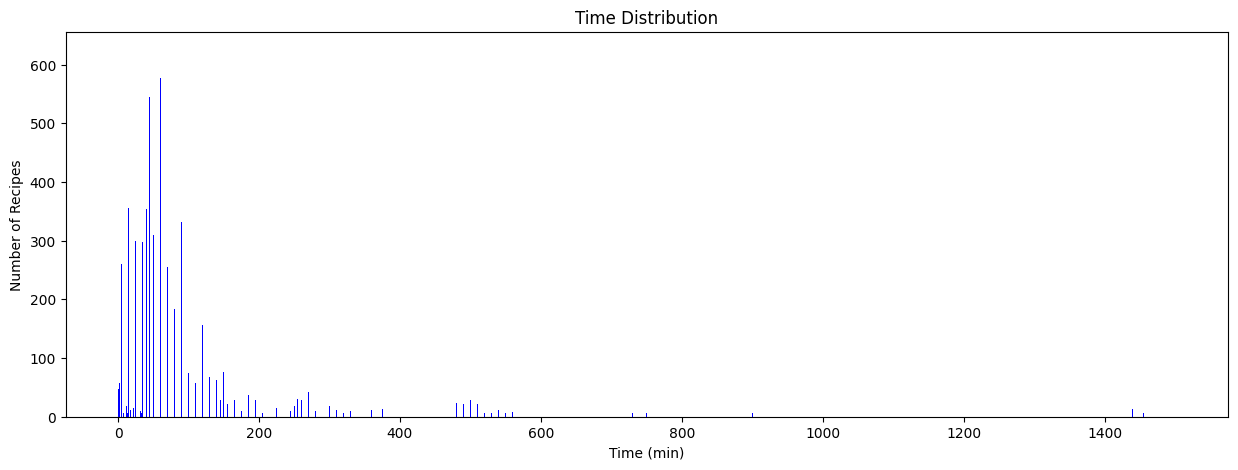

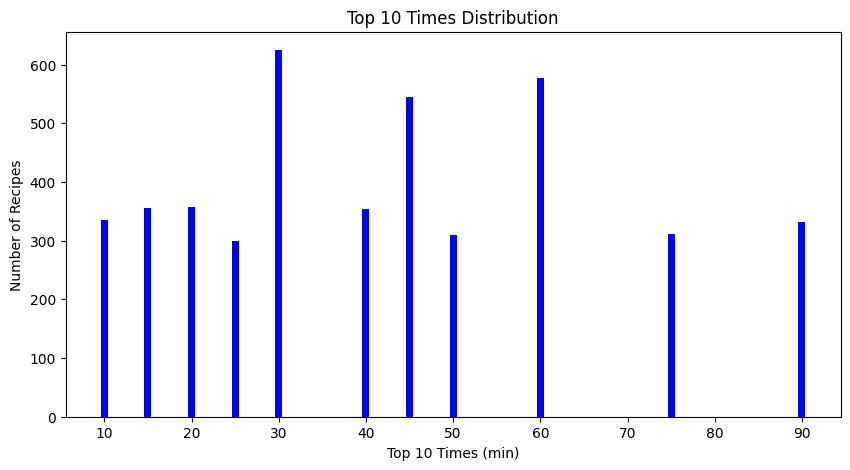

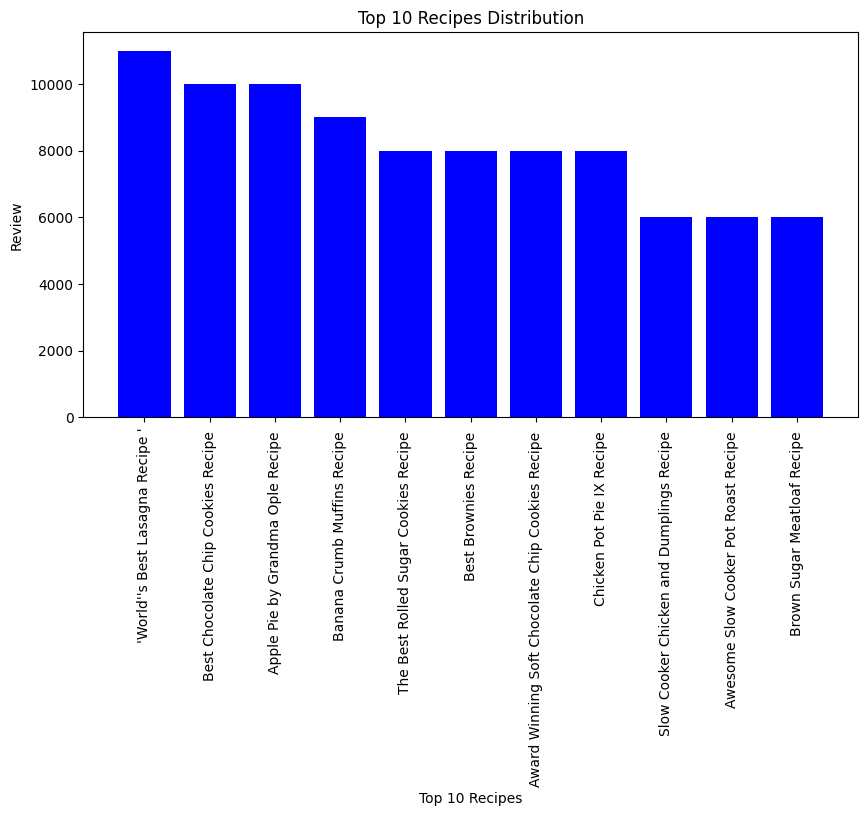

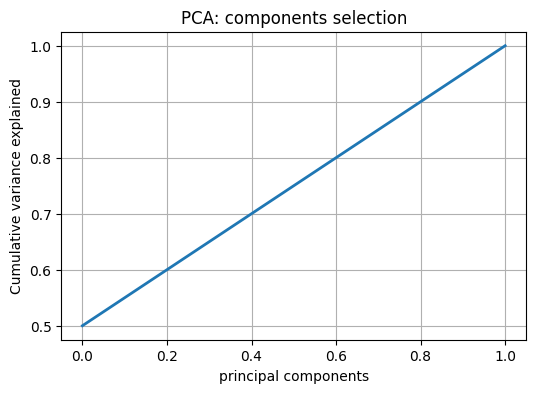

---------------------------------------- Welcome to Pendia ----------------------------------------
1- Log In;
2- Sing In;
0- Leave;
0
Bye, Have a Great Time!


In [1436]:
if __name__ == '__main__':
    main()